In [1]:
import sys

if (
    "/Users/carterblair/waterloo/research/BanditLiquidDem/banditLiquidDem"
    not in sys.path
):
    sys.path.append(
        "/Users/carterblair/waterloo/research/BanditLiquidDem/banditLiquidDem"
    )
print(sys.path)

['/Users/carterblair/waterloo/research/BanditLiquidDem/banditLiquidDem/experiments', '/Users/carterblair/opt/anaconda3/envs/LDE/lib/python310.zip', '/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10', '/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/lib-dynload', '', '/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages', '/Users/carterblair/waterloo/research/BanditLiquidDem/banditLiquidDem']


In [2]:
import os
from exp_framework.Ensemble import Ensemble, PretrainedEnsemble, StudentExpertEnsemble
from exp_framework.delegation import (
    DelegationMechanism,
    UCBDelegationMechanism,
    ProbaSlopeDelegationMechanism,
    RestrictedMaxGurusDelegationMechanism,
    StudentExpertDelegationMechanism,
)
from exp_framework.learning import Net
from exp_framework.experiment import (
    Experiment,
    calculate_avg_std_test_accs,
    calculate_avg_std_train_accs,
    calculate_avg_std_test_accs_per_trial,
)
from avalanche.training.supervised import Naive
from matplotlib import pyplot as plt
from exp_framework.data_utils import Data
from avalanche.benchmarks.classic import RotatedMNIST, SplitMNIST
import numpy as np
import matplotlib as mpl
import seaborn as sns
from itertools import product
import pandas as pd
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from avalanche.training import plugins as plg
from exp_framework.MinibatchEvalAccuracy import MinibatchEvalAccuracy
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics

/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### learning the mapping $\mathcal{X} \rightarrow \mathcal{G}$ (i.e. $\mathcal{X} \rightarrow \mathcal{Y}\times\mathcal{C}$)

### Set up global experiment settings

In [3]:
batch_size = 128
window_size = 400
num_trials = 10
n_voters = 8

ensemble_width = 64
single_width = 512

exp_name_suffix = "CAI-experiments-feb16"  # adjust as useful to avoid overwriting data!

#### Create Delegation Mechanisms

### Create Delegation Mechanisms and Ensembles

For simplicity, only explore full ensemble and variants of ProbaSlopeDelegationMechanism since they can be created programmatically.

In [4]:
def get_ensembles_dict(lo_num_gurus=[1, 2, 3, 4]):
    NOOP_del_mech = DelegationMechanism(batch_size=batch_size, window_size=window_size)
    NOOP_del_mech2 = DelegationMechanism(batch_size=batch_size, window_size=window_size)

    probability_functions = [
        "random_better",
        "probabilistic_better",
        "probabilistic_weighted",
        "max_diversity",
    ]
    score_functions = [
        "accuracy_score",
        "balanced_accuracy_score",
        "f1_score",
        # "precision_score",
        # "recall_score",
        # "top_k_accuracy_score",
        # "roc_auc_score",
        # "log_loss_score",
        # "max_diversity",
    ]
    # probability_functions = ["max_diversity"]
    # score_functions = ["accuracy_score"]

    del_mechs = {"full-ensemble": NOOP_del_mech}
    for prob_func, score_func in product(probability_functions, score_functions):
        for num_gurus in lo_num_gurus:
            dm = ProbaSlopeDelegationMechanism(
                batch_size=batch_size,
                window_size=window_size,
                max_active=num_gurus,
                probability_function=prob_func,
                score_method=score_func,
            )
            del_mechs[f"{prob_func}-{score_func}-num_gurus-{num_gurus}"] = dm

    for num_train_gurus in lo_num_gurus:
        for num_test_gurus in lo_num_gurus:
            dm = StudentExpertDelegationMechanism(
                batch_size=batch_size,
                window_size=window_size,
                max_active_train=num_train_gurus,
                max_active_test=num_test_gurus,
            )
            del_mechs[
                f"StudentExpert-num_train_gurus-{num_train_gurus}-num_test_gurus-{num_test_gurus}"
            ] = dm

    ensembles_dict = {
        dm_name: Ensemble(
            training_epochs=1,
            n_voters=n_voters,
            delegation_mechanism=dm,
            name=dm_name,
            input_dim=28 * 28,
            output_dim=10,
            width=ensemble_width,
        )
        for dm_name, dm in del_mechs.items()
    }
    ensembles_dict["single_Net"] = Ensemble(
        training_epochs=1,
        n_voters=1,
        delegation_mechanism=NOOP_del_mech2,
        name="single_Net",
        input_dim=28 * 28,
        output_dim=10,
        width=single_width,
    )
    return ensembles_dict

#### Create Avalanche Strategies to Compare Against

In [5]:
def initialize_strategies_to_evaluate():
    plugins_to_evaluate = {
        "AGEM": plg.AGEMPlugin(
            patterns_per_experience=50, sample_size=256
        ),  # https://arxiv.org/pdf/1812.00420.pdf
        "CoPE": plg.CoPEPlugin(p_size=10),  # has default parameters in Avalanche
        "CWR": "LATER",  # mostly has default parameters (?)
        "EWC": plg.EWCPlugin(ewc_lambda=0.001),
        "GDumb": plg.GDumbPlugin(),
        "GEM": plg.GEMPlugin(
            patterns_per_experience=5120, memory_strength=0.5
        ),  # https://arxiv.org/pdf/1706.08840.pdf
        # "GSS_greedy": plg.GSS_greedyPlugin(),
        "LFL": plg.LFLPlugin(lambda_e=0.0016),  # https://arxiv.org/pdf/1607.00122.pdf
        "LwF": plg.LwFPlugin(),
        "Replay": plg.ReplayPlugin(mem_size=100),
        "SynapticIntelligence": plg.SynapticIntelligencePlugin(si_lambda=0.5),
        "MAS": plg.MASPlugin(),
        "TrainGeneratorAfterExp": plg.TrainGeneratorAfterExpPlugin(),
        "RWalk": plg.RWalkPlugin(),
        # "GenerativeReplay": plg.GenerativeReplayPlugin()
        # "BiC": plg.BiCPlugin(),
        "MIR": plg.MIRPlugin(batch_size_mem=10),
    }

    strategies_to_evaluate = {}
    for name, pte in plugins_to_evaluate.items():
        model = Net(input_dim=28 * 28, output_dim=10, width=single_width)
        if name == "CWR":
            strategies_to_evaluate["CWR"] = plg.CWRStarPlugin(model)
            pte = strategies_to_evaluate["CWR"]
        if name == "LFL":
            from avalanche.models import SimpleMLP

            model = SimpleMLP(num_classes=10, hidden_layers=2, hidden_size=single_width)

        optimize = optim.Adam(model.parameters(), lr=0.001)

        mb_eval = MinibatchEvalAccuracy()
        evp = EvaluationPlugin(
            accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
            mb_eval,
        )
        cl_strategy = Naive(
            model=model,
            optimizer=optimize,
            criterion=CrossEntropyLoss(),
            train_mb_size=batch_size,
            train_epochs=1,
            eval_mb_size=batch_size,
            # plugins=[pte, evp],
            plugins=[pte, evp, mb_eval],
        )
        strategies_to_evaluate[name] = (cl_strategy, evp)

    return strategies_to_evaluate

# Single Active Voter

### Train Ensemble - single active voter

In [6]:
# Train ensembles - single guru

# data = RotatedMNIST(n_experiences=5, seed=0)

ensembles_dict = get_ensembles_dict()

exp = Experiment(
    n_trials=num_trials,
    ensembles=list(ensembles_dict.values()),
    # benchmark=data,
    dataset_name="RotatedMNIST",
    strategies_to_evaluate=initialize_strategies_to_evaluate,
)
_ = exp.run()

  0%|          | 0/10 [00:00<?, ?it/s]

Starting trial  0


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Creating dataset
Training: AGEM!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:16<00:00, 28.65it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2499
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9262
-- >> End of training phase << --
Training: CoPE!
Using the Pseudo-Prototypical-Proxy loss for CoPE.
-- >> Start of training phase << --
  0%|          | 1/469 [00:00<00:34, 13.43it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 58.9800
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1797
-- >> End of training phase << --
Training: CWR!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:16<00:00, 28.35it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3619
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8901
-- >> End of training phase << --
Training: EWC!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:16<00:00, 28.50it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train

 10%|█         | 1/10 [2:01:55<18:17:17, 7315.24s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.0939
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9691
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 2.9839
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4440
Starting trial  1


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Creating dataset
Training: AGEM!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:16<00:00, 28.77it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2508
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9266
-- >> End of training phase << --
Training: CoPE!
Using the Pseudo-Prototypical-Proxy loss for CoPE.
-- >> Start of training phase << --
  0%|          | 1/469 [00:00<00:33, 14.13it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 91.7585
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0469
-- >> End of training phase << --
Training: CWR!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:16<00:00, 28.73it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3581
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8896
-- >> End of training phase << --
Training: EWC!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:16<00:00, 28.81it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train

 20%|██        | 2/10 [3:40:05<14:23:36, 6477.05s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.0868
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9714
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 1.8252
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.6653
Starting trial  2


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Creating dataset
Training: AGEM!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.61it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2573
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9232
-- >> End of training phase << --
Training: CoPE!
Using the Pseudo-Prototypical-Proxy loss for CoPE.
-- >> Start of training phase << --
  0%|          | 1/469 [00:00<00:28, 16.21it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 62.7754
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.2031
-- >> End of training phase << --
Training: CWR!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.75it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3540
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8913
-- >> End of training phase << --
Training: EWC!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.63it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train

 30%|███       | 3/10 [4:51:32<10:38:59, 5477.14s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.1015
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9693
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 3.0050
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4583
Starting trial  3


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Creating dataset
Training: AGEM!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 33.49it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2552
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9245
-- >> End of training phase << --
Training: CoPE!
Using the Pseudo-Prototypical-Proxy loss for CoPE.
-- >> Start of training phase << --
  0%|          | 1/469 [00:00<00:29, 16.14it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 61.2971
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1719
-- >> End of training phase << --
Training: CWR!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:13<00:00, 33.77it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3550
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8925
-- >> End of training phase << --
Training: EWC!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:13<00:00, 33.78it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train

 40%|████      | 4/10 [6:03:45<8:22:31, 5025.27s/it] 


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.1006
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9691
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 2.1779
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.5553
Starting trial  4


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Creating dataset
Training: AGEM!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.43it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2558
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9246
-- >> End of training phase << --
Training: CoPE!
Using the Pseudo-Prototypical-Proxy loss for CoPE.
-- >> Start of training phase << --
  0%|          | 1/469 [00:00<00:30, 15.59it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 74.2485
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1562
-- >> End of training phase << --
Training: CWR!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.64it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3607
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8887
-- >> End of training phase << --
Training: EWC!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.48it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train

 50%|█████     | 5/10 [7:15:54<6:37:50, 4774.20s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.0716
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9770
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 0.8842
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.7942
Starting trial  5


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Creating dataset
Training: AGEM!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.87it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2500
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9253
-- >> End of training phase << --
Training: CoPE!
Using the Pseudo-Prototypical-Proxy loss for CoPE.
-- >> Start of training phase << --
  0%|          | 1/469 [00:00<00:30, 15.52it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 82.7431
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1172
-- >> End of training phase << --
Training: CWR!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.65it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3602
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8900
-- >> End of training phase << --
Training: EWC!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.92it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train

 60%|██████    | 6/10 [8:28:06<5:08:14, 4623.75s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.1053
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9665
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 1.4688
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.6092
Starting trial  6


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Creating dataset
Training: AGEM!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.59it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2600
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9243
-- >> End of training phase << --
Training: CoPE!
Using the Pseudo-Prototypical-Proxy loss for CoPE.
-- >> Start of training phase << --
  0%|          | 1/469 [00:00<00:30, 15.43it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 81.5046
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1016
-- >> End of training phase << --
Training: CWR!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.69it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3577
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8921
-- >> End of training phase << --
Training: EWC!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.55it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train

 70%|███████   | 7/10 [9:40:13<3:46:20, 4526.73s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.0928
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9709
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 1.5779
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.7057
Starting trial  7


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Creating dataset
Training: AGEM!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.59it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2567
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9235
-- >> End of training phase << --
Training: CoPE!
Using the Pseudo-Prototypical-Proxy loss for CoPE.
-- >> Start of training phase << --
  0%|          | 1/469 [00:00<00:29, 15.76it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 55.8056
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0703
-- >> End of training phase << --
Training: CWR!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.82it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3543
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8906
-- >> End of training phase << --
Training: EWC!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.50it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train

 80%|████████  | 8/10 [10:51:57<2:28:31, 4455.82s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.0781
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9758
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 1.1615
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.7958
Starting trial  8


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Creating dataset
Training: AGEM!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.43it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2470
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9275
-- >> End of training phase << --
Training: CoPE!
Using the Pseudo-Prototypical-Proxy loss for CoPE.
-- >> Start of training phase << --
  0%|          | 1/469 [00:00<00:30, 15.53it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 84.9243
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0781
-- >> End of training phase << --
Training: CWR!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.66it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3626
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8890
-- >> End of training phase << --
Training: EWC!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.11it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train

 90%|█████████ | 9/10 [12:05:19<1:13:58, 4438.99s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.0900
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9730
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 2.6686
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.5242
Starting trial  9


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Creating dataset
Training: AGEM!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.22it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2498
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9266
-- >> End of training phase << --
Training: CoPE!
Using the Pseudo-Prototypical-Proxy loss for CoPE.
-- >> Start of training phase << --
  0%|          | 1/469 [00:00<00:30, 15.41it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 110.1559
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0859
-- >> End of training phase << --
Training: CWR!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.25it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3538
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8912
-- >> End of training phase << --
Training: EWC!
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.47it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/trai

100%|██████████| 10/10 [13:20:27<00:00, 4802.79s/it] 


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.0857
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9732
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 1.8046
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.6451


### Save and Print Results

In [7]:
exp_metrics = exp.batch_metric_values
num_trials = exp.n_trials

result_dict = {}

for ens in exp_metrics.keys():
    num_contexts = len(exp_metrics[ens][0]["experience_test_acc"])

    ens_values = np.zeros((num_trials, num_contexts))

    for i in range(num_trials):
        for j in range(num_contexts):
            # ith trial, jth context
            ens_values[i, j] = exp_metrics[ens][i]["experience_test_acc"][j]

    # calculate the mean for each context
    experience_mean_values = np.mean(ens_values, axis=0)
    experience_std_values = np.std(ens_values, axis=0)

    # calculate the mean test acc for each trial
    trial_mean_values = np.mean(ens_values, axis=1)

    # calculate the mean and std of the mean test acc for each trial
    avg_test_acc = np.mean(trial_mean_values)
    std_test_acc = np.std(trial_mean_values)

    # in our final df we want to have the following columns:
    # ensemble_name, avg_test_acc, context_1_test_acc, context_2_test_acc, ..., context_n_test_acc
    # we want to set up the dictionary to be able to easily convert to a pandas dataframe
    result_dict[ens] = {
        "avg_test_acc": f"${avg_test_acc*100:.2f} \pm {std_test_acc*100:.2f}$"
    }
    for i in range(num_contexts):
        result_dict[ens][
            f"context_{i+1}_test_acc"
        ] = f"${experience_mean_values[i]*100:.2f} \pm {experience_std_values[i]*100:.2f}$"

table_df = pd.DataFrame(result_dict).T
# add the ensemble name as the first column
table_df["ensemble"] = table_df.index
table_df = table_df.reset_index(drop=True)

# move the ensemble name to the first column
cols = table_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
table_df = table_df[cols]


# sort the rows based on the avg_test_acc
table_df = table_df.sort_values(by="avg_test_acc", ascending=False)

file_prefix = f"domain_incremental-trials={num_trials}-batch_size={batch_size}-window_size={window_size}-num_voters={n_voters}-width={ensemble_width}-{exp_name_suffix}"
path = "results"

filepath = f"{path}/{file_prefix}-tabledata-test-feb16.csv"
table_df.to_csv(filepath, index=False)

table_df.head(100)

,ensemble,avg_test_acc,context_1_test_acc,context_2_test_acc,context_3_test_acc,context_4_test_acc,context_5_test_acc
71,GEM,$95.41 \pm 0.60$,$94.66 \pm 1.44$,$94.93 \pm 1.50$,$94.72 \pm 0.90$,$95.71 \pm 0.81$,$97.05 \pm 0.21$
54,StudentExpert-num_train_gurus-2-num_test_gurus-2,$92.46 \pm 1.39$,$93.59 \pm 0.62$,$89.21 \pm 3.27$,$92.34 \pm 2.41$,$92.12 \pm 3.94$,$95.05 \pm 0.68$
55,StudentExpert-num_train_gurus-2-num_test_gurus-3,$91.72 \pm 1.31$,$93.56 \pm 0.76$,$87.53 \pm 4.06$,$90.43 \pm 2.10$,$92.16 \pm 3.07$,$94.93 \pm 0.59$
53,StudentExpert-num_train_gurus-2-num_test_gurus-1,$91.27 \pm 3.20$,$93.29 \pm 0.65$,$84.19 \pm 16.93$,$92.25 \pm 2.31$,$91.80 \pm 4.10$,$94.82 \pm 0.64$
56,StudentExpert-num_train_gurus-2-num_test_gurus-4,$89.03 \pm 4.05$,$93.05 \pm 1.42$,$77.91 \pm 19.79$,$88.64 \pm 4.82$,$91.29 \pm 3.18$,$94.26 \pm 0.84$
...,...,...,...,...,...,...,...
25,probabilistic_weighted-accuracy_score-num_gurus-1,$49.53 \pm 6.80$,$93.71 \pm 0.43$,$25.14 \pm 12.65$,$27.02 \pm 5.02$,$60.96 \pm 26.70$,$40.84 \pm 22.09$
29,probabilistic_weighted-balanced_accuracy_score...,$49.51 \pm 6.95$,$93.72 \pm 0.44$,$25.03 \pm 12.86$,$28.06 \pm 4.31$,$60.38 \pm 26.48$,$40.38 \pm 22.88$
13,probabilistic_better-accuracy_score-num_gurus-1,$49.38 \pm 7.12$,$93.76 \pm 0.48$,$25.15 \pm 12.70$,$27.65 \pm 4.21$,$60.08 \pm 27.04$,$40.26 \pm 22.59$
70,GDumb,$32.26 \pm 6.77$,$31.92 \pm 7.98$,$31.09 \pm 9.56$,$30.95 \pm 8.21$,$34.06 \pm 8.16$,$33.27 \pm 7.65$


In [9]:
# make a df with mean and std in separate columns using result_dict
exp_metrics = exp.batch_metric_values
num_trials = exp.n_trials

result_dict = {}

for ens in exp_metrics.keys():
    num_contexts = len(exp_metrics[ens][0]["experience_test_acc"])

    ens_values = np.zeros((num_trials, num_contexts))

    for i in range(num_trials):
        for j in range(num_contexts):
            # ith trial, jth context
            ens_values[i, j] = exp_metrics[ens][i]["experience_test_acc"][j]

    # calculate the mean for each context
    experience_mean_values = np.mean(ens_values, axis=0)
    experience_std_values = np.std(ens_values, axis=0)

    # calculate the mean test acc for each trial
    trial_mean_values = np.mean(ens_values, axis=1)

    # calculate the mean and std of the mean test acc for each trial
    avg_test_acc = np.mean(trial_mean_values)
    std_test_acc = np.std(trial_mean_values)

    # in our final df we want to have the following columns:
    # ensemble_name, avg_test_acc, context_1_test_acc, context_2_test_acc, ..., context_n_test_acc
    # we want to set up the dictionary to be able to easily convert to a pandas dataframe
    result_dict[ens] = {
        "avg_test_acc": (avg_test_acc, std_test_acc),
    }
    for i in range(num_contexts):
        result_dict[ens][
            f"context_{i+1}_test_acc"
        ] = (experience_mean_values[i], experience_std_values[i])

viz_df = pd.DataFrame(result_dict).T
# add the ensemble name as the first column
viz_df["ensemble"] = viz_df.index
viz_df = viz_df.reset_index(drop=True)

# move the ensemble name to the first column
cols = viz_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
viz_df = viz_df[cols]


# sort the rows based on the avg_test_acc
viz_df = viz_df.sort_values(by="avg_test_acc", ascending=False)

file_prefix = f"domain_incremental-trials={num_trials}-batch_size={batch_size}-window_size={window_size}-num_voters={n_voters}-width={ensemble_width}-{exp_name_suffix}"
path = "results"

filepath = f"{path}/{file_prefix}-vizdata-test-feb16.csv"
viz_df.to_csv(filepath, index=False)

viz_df.head(100)

,ensemble,avg_test_acc,context_1_test_acc,context_2_test_acc,context_3_test_acc,context_4_test_acc,context_5_test_acc
71,GEM,"(0.9541380000000002, 0.006026212409133942)","(0.9465999999999999, 0.014403888363910615)","(0.9492900000000001, 0.015020016644464817)","(0.94718, 0.009012302702417386)","(0.9571099999999999, 0.008097586060055199)","(0.97051, 0.0021449708622729583)"
54,StudentExpert-num_train_gurus-2-num_test_gurus-2,"(0.9246182753164556, 0.013885457345339499)","(0.9359276107594937, 0.006200238343175798)","(0.8920984968354431, 0.03266134689449956)","(0.9233682753164556, 0.024106611538909573)","(0.9212124208860759, 0.03939243499197619)","(0.9504845727848099, 0.0067720794042057594)"
55,StudentExpert-num_train_gurus-2-num_test_gurus-3,"(0.9172231012658228, 0.013085873517784041)","(0.9356408227848101, 0.007612505844209801)","(0.8753461234177214, 0.040639731286380966)","(0.9042919303797469, 0.020960281996594964)","(0.9215585443037975, 0.030720661011421756)","(0.949278085443038, 0.005929331640107144)"
53,StudentExpert-num_train_gurus-2-num_test_gurus-1,"(0.9127116297468355, 0.0320368292562437)","(0.932901503164557, 0.006544144661490516)","(0.8419303797468356, 0.1693145655383906)","(0.9224881329113923, 0.023097074368866224)","(0.9179885284810126, 0.04098591045100948)","(0.9482496044303798, 0.006399500144016283)"
56,StudentExpert-num_train_gurus-2-num_test_gurus-4,"(0.8903105221518987, 0.04051974347273477)","(0.9305181962025317, 0.01417430054433468)","(0.7791139240506328, 0.19787552409417944)","(0.8864220727848101, 0.04818586094038817)","(0.912915348101266, 0.03176842745550232)","(0.9425830696202533, 0.008420640383642907)"
...,...,...,...,...,...,...,...
25,probabilistic_weighted-accuracy_score-num_gurus-1,"(0.495334256329114, 0.06798621152553794)","(0.9370747626582278, 0.00430586435049794)","(0.2514339398734177, 0.1264656804673117)","(0.27019382911392403, 0.05017350393051294)","(0.6096024525316455, 0.2669898758103141)","(0.4083662974683544, 0.22093954204002522)"
29,probabilistic_weighted-balanced_accuracy_score...,"(0.49514042721518986, 0.0694779983484177)","(0.9371835443037974, 0.004416805394132845)","(0.25028678797468357, 0.12860482160326372)","(0.2805775316455696, 0.04306274973480212)","(0.6038469145569619, 0.2648234116734197)","(0.4038073575949367, 0.22881813091593703)"
13,probabilistic_better-accuracy_score-num_gurus-1,"(0.49381329113924055, 0.07116469128986923)","(0.9376384493670887, 0.004788516894345084)","(0.2515427215189874, 0.12702401414395512)","(0.27648338607594936, 0.04207461719925623)","(0.6007614715189874, 0.2703770203720361)","(0.40264042721518994, 0.2259456016752392)"
70,GDumb,"(0.32256599999999996, 0.06765128944816941)","(0.31917999999999996, 0.07984214175484021)","(0.31087000000000004, 0.0955991532389278)","(0.30947, 0.08207966922447969)","(0.34063999999999994, 0.08157950968227255)","(0.3326699999999999, 0.0764996346396504)"


In [6]:
# batch_metrics = exp.get_aggregate_batch_metrics()
# dfs = []
# for ens, metric_dict in batch_metrics.items():
#     df = pd.DataFrame.from_dict(metric_dict, orient="index")
#     df["ensemble_name"] = ens
#     dfs.append(df)
# single_active_df = pd.concat(dfs)
# col_order = [len(single_active_df.columns) - 1] + list(
#     range(len(single_active_df.columns) - 1)
# )
# single_active_df = single_active_df[single_active_df.columns[col_order]]
# file_prefix = f"domain_incremental_single_guru-trials={num_trials}-batch_size={batch_size}_window_size={window_size}-{exp_name_suffix}"
# path = "results"

# if not os.path.exists(path):
#     os.mkdir(path)

# filepath = f"{path}/{file_prefix}.csv"
# single_active_df.to_csv(filepath)

# #######
# # Below code is, as yet, untested for domain-incremental learning
# #######

# # Save the test/train experience results into their own files for easy analysis/table-making

# # TRAIN ACC
# key = "experience_train_acc-mean"
# means_df = single_active_df[
#     single_active_df["ensemble_name"] == "experience_train_acc-mean"
# ]
# means_df.columns = ["measure_name", "ensemble_name", "experience_means"]
# stds_df = single_active_df[
#     single_active_df["ensemble_name"] == "experience_train_acc-std"
# ]
# stds_df.columns = ["measure_name", "ensemble_name", "experience_stds"]

# # means_df = pd.merge(means_df, stds_df, on=['measure_name'])
# means_df = pd.merge(
#     means_df, stds_df.drop(["ensemble_name"], axis=1), on="measure_name"
# )
# new_rows = []
# n_contexts = 0

# for index, row in means_df.iterrows():
#     measure_name, ensemble_name, means, stds = (
#         row.tolist()[0],
#         row.tolist()[1],
#         row.tolist()[2],
#         row.tolist()[3],
#     )
#     means = eval(means)
#     mean_mean = round(np.mean(means), 4)
#     stds = eval(stds)
#     mean_std = round(np.mean(stds), 4)
#     measure_values = [f"{means[idx]} ({stds[idx]})" for idx in range(len(means))]
#     n_contexts = len(measure_values)

#     new_row = [measure_name, ensemble_name, f"{mean_mean} ({mean_std})"]
#     new_row += measure_values
#     new_rows.append(new_row)

# cols = ["ensemble_name", "measure_name", "mean_acc"] + [
#     f"Context {i+1}" for i in range(n_contexts)
# ]
# table_df = pd.DataFrame(new_rows, columns=cols)
# table_df = table_df.sort_values(by="mean_acc", ascending=False, ignore_index=True)

# filepath = f"{path}/{file_prefix}-tabledata-train.csv"
# table_df.to_csv(filepath, index=False)


# # TEST ACC
# key = "experience_test_acc-mean"
# means_df = single_active_df[
#     single_active_df["ensemble_name"] == "experience_test_acc-mean"
# ]
# means_df.columns = ["measure_name", "ensemble_name", "experience_means"]
# stds_df = single_active_df[
#     single_active_df["ensemble_name"] == "experience_test_acc-std"
# ]
# stds_df.columns = ["measure_name", "ensemble_name", "experience_stds"]

# # means_df = pd.merge(means_df, stds_df, on=['measure_name'])
# means_df = pd.merge(
#     means_df, stds_df.drop(["ensemble_name"], axis=1), on="measure_name"
# )
# new_rows = []
# n_contexts = 0

# for index, row in means_df.iterrows():
#     measure_name, ensemble_name, means, stds = (
#         row.tolist()[0],
#         row.tolist()[1],
#         row.tolist()[2],
#         row.tolist()[3],
#     )
#     means = eval(means)
#     mean_mean = round(np.mean(means), 4)
#     stds = eval(stds)
#     mean_std = round(np.mean(stds), 4)
#     measure_values = [f"{means[idx]} ({stds[idx]})" for idx in range(len(means))]
#     n_contexts = len(measure_values)

#     new_row = [measure_name, ensemble_name, f"{mean_mean} ({mean_std})"]
#     new_row += measure_values
#     new_rows.append(new_row)

# cols = ["ensemble_name", "measure_name", "mean_acc"] + [
#     f"Context {i+1}" for i in range(n_contexts)
# ]
# table_df = pd.DataFrame(new_rows, columns=cols)
# table_df = table_df.sort_values(by="mean_acc", ascending=False, ignore_index=True)

# filepath = f"{path}/{file_prefix}-tabledata-test.csv"
# table_df.to_csv(filepath, index=False)

In [7]:
# Print results - single guru

# Collect and print train accuracies - aggregate and by batch
train_results_dict = dict()
for ens_name, ensemble in ensembles_dict.items():
    train_acc, train_acc_std = calculate_avg_std_train_accs(exp, ens_name, num_trials)
    train_results_dict[ens_name] = (train_acc, train_acc_std)

for strat_name, (strat, eval_plugin) in initialize_strategies_to_evaluate().items():
    train_acc, train_acc_std = calculate_avg_std_train_accs(exp, strat_name, num_trials)
    train_results_dict[strat_name] = (train_acc, train_acc_std)

for ens_name, (train_acc, train_acc_std) in train_results_dict.items():
    print(
        f"Mean train acc for {ens_name}: {round(np.mean(train_acc), 3)}+-{round(np.mean(train_acc_std), 3)}"
    )
# for ens_name, (train_acc, train_acc_std) in train_results_dict.items():
#     print(f"All train accs for {ens_name}: {train_acc}")

print("--------------")

# Collect and print test accuracies
# results_dict = dict()
# for ens_name, ensemble in ensembles_dict.items():
#     test_acc, test_acc_std = calculate_avg_std_test_accs(exp, ens_name, num_trials)
#     results_dict[ens_name] = (test_acc, test_acc_std)

# for strat_name, (strat, eval_plugin) in initialize_strategies_to_evaluate().items():
#     test_acc, test_acc_std = calculate_avg_std_test_accs(exp, strat_name, num_trials)
#     results_dict[strat_name] = (test_acc, test_acc_std)

# for ens_name, (test_acc, test_acc_std) in results_dict.items():
#     print(
#         f"Mean test acc for {ens_name}: {round(np.mean(test_acc), 3)}+-{round(np.mean(test_acc_std), 3)}"
#     )

results_dict = dict()

for ens_name, ensemble in ensembles_dict.items():
    test_acc, _ = calculate_avg_std_test_accs_per_trial(exp, ens_name, num_trials)
    print(
        f"Mean test acc for {ens_name}: {round(np.mean(test_acc), 3)}+-{round(np.std(test_acc), 3)}"
    )
    results_dict[ens_name] = (np.mean(test_acc), np.std(test_acc))

for strat_name, (strat, eval_plugin) in initialize_strategies_to_evaluate().items():
    test_acc, _ = calculate_avg_std_test_accs_per_trial(exp, strat_name, num_trials)
    print(
        f"Mean test acc for {strat_name}: {round(np.mean(test_acc), 3)}+-{round(np.std(test_acc), 3)}"
    )
    results_dict[strat_name] = (np.mean(test_acc), np.std(test_acc))

Mean train acc for full-ensemble: 0.92+-0.021
Mean train acc for random_better-accuracy_score-num_gurus-1: 0.9+-0.037
Mean train acc for random_better-accuracy_score-num_gurus-2: 0.911+-0.026
Mean train acc for random_better-accuracy_score-num_gurus-3: 0.915+-0.023
Mean train acc for random_better-accuracy_score-num_gurus-4: 0.914+-0.022
Mean train acc for random_better-balanced_accuracy_score-num_gurus-1: 0.9+-0.036
Mean train acc for random_better-balanced_accuracy_score-num_gurus-2: 0.912+-0.026
Mean train acc for random_better-balanced_accuracy_score-num_gurus-3: 0.915+-0.023
Mean train acc for random_better-balanced_accuracy_score-num_gurus-4: 0.915+-0.022
Mean train acc for random_better-f1_score-num_gurus-1: 0.9+-0.036
Mean train acc for random_better-f1_score-num_gurus-2: 0.91+-0.027
Mean train acc for random_better-f1_score-num_gurus-3: 0.915+-0.023
Mean train acc for random_better-f1_score-num_gurus-4: 0.913+-0.023
Mean train acc for probabilistic_better-accuracy_score-num_gu

/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


In [8]:
df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["mean", "std"])
df = df.reset_index()
df = df.rename(columns={"index": "name"})
df = df.sort_values(by="mean", ascending=False, ignore_index=True)
# write to csv in results/keepers/class_inc_avgs.csv
df.to_csv(f"results/keepers/domain_inc_avgs-{exp_name_suffix}.csv")

# Explore Results

(leftover copied code from other file, not adapted for the above code)

NameError: name 'full_avg_test_accs' is not defined

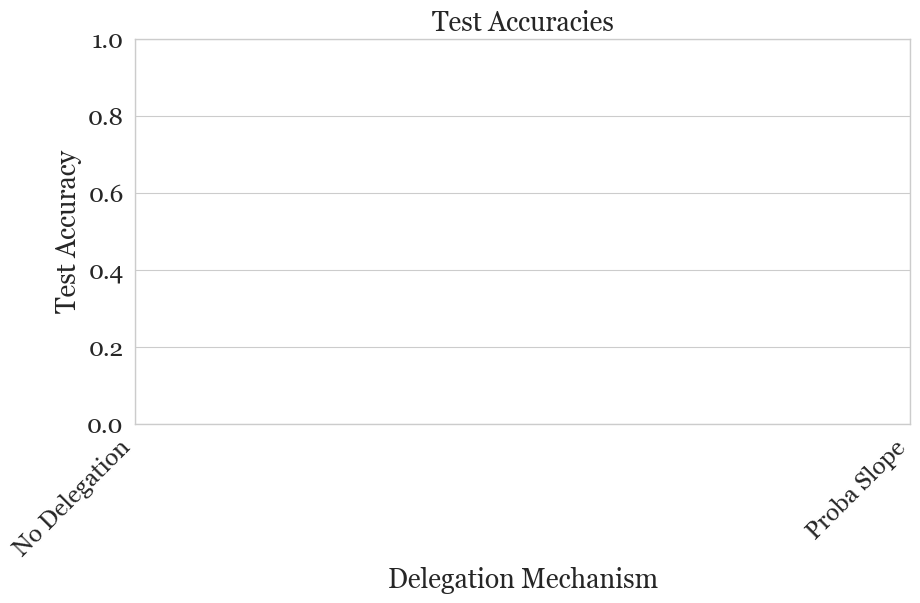

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Georgia"

# set colors for each bar. Use pastel
colors = sns.color_palette("pastel")
# assign colors for each bar

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_title("Test Accuracies")
ax.set_ylabel("Test Accuracy")
ax.set_xlabel("Delegation Mechanism")
# ax.set_xticks([0, 1, 2])
# ax.set_xticklabels(
#     ["No Delegation", "Proba Slope", "Restricted Max Guru"], rotation=45, ha="right"
# )
ax.set_xticks([0, 1])
ax.set_xticklabels(["No Delegation", "Proba Slope"], rotation=45, ha="right")
# Data for bar plot
means = [
    np.mean(full_avg_test_accs),
    np.mean(proba_slope_avg_test_accs),
    # np.mean(restricted_max_guru_avg_test_accs),
]
stds = [
    np.std(full_avg_test_accs),
    np.std(proba_slope_avg_test_accs),
    # np.std(restricted_max_guru_avg_test_accs),
]

# Create each bar individually to set different colors
for i in range(len(ensembles)):
    ax.bar(i, means[i], color=colors[i], yerr=stds[i], capsize=10)

plt.tight_layout()
plt.show()

In [ ]:
proba_slope_avg_train_accs, proba_slope_std_train_accs = calculate_avg_std_train_accs(
    exp, "proba_slope_delegations", num_trials
)
full_avg_train_accs, full_std_train_accs = calculate_avg_std_train_accs(
    exp, "full_ensemble", num_trials
)

# (
#     restricted_max_guru_avg_train_accs,
#     restricted_max_guru_std_train_accs,
# ) = calculate_avg_std_train_accs(exp, "restricted_max_guru_delegations", num_trials)

print(
    "Mean train accs for proba_slope delegation ensemble: ",
    np.mean(proba_slope_avg_train_accs),
)
print("Mean train accs for full ensemble: ", np.mean(full_avg_train_accs))

# print(
#     "Mean train accs for restricted_max_guru delegation ensemble: ",
#     np.mean(restricted_max_guru_avg_train_accs),
# )

In [ ]:
train_splits = exp.train_splits

In [ ]:
sns.set(style="whitegrid", palette="pastel", context="paper")

# Set the font to Georgia
mpl.rcParams["font.family"] = "Georgia"
mpl.rcParams["font.size"] = 12
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 16

fig, ax = plt.subplots(figsize=(10, 5))

colors = sns.color_palette("pastel")
proba_slope_color = colors[1]
full_color = colors[0]
restricted_max_guru_color = colors[2]

ax.plot(
    proba_slope_avg_train_accs,
    label="ProbaSlope Delegation Ensemble",
    color=proba_slope_color,
    linewidth=2,
)
ax.fill_between(
    range(len(proba_slope_avg_train_accs)),
    np.array(proba_slope_avg_train_accs) - np.array(proba_slope_std_train_accs),
    np.array(proba_slope_avg_train_accs) + np.array(proba_slope_std_train_accs),
    color=proba_slope_color,
    alpha=0.3,
)

ax.plot(full_avg_train_accs, label="Full Ensemble", color=full_color, linewidth=2)
ax.fill_between(
    range(len(full_avg_train_accs)),
    np.array(full_avg_train_accs) - np.array(full_std_train_accs),
    np.array(full_avg_train_accs) + np.array(full_std_train_accs),
    color=full_color,
    alpha=0.3,
)

# ax.plot(
#     restricted_max_guru_avg_train_accs,
#     label="Restricted Max Guru Delegation Ensemble",
#     color=restricted_max_guru_color,
#     linewidth=2,
# )
# ax.fill_between(
#     range(len(restricted_max_guru_avg_train_accs)),
#     np.array(restricted_max_guru_avg_train_accs)
#     - np.array(restricted_max_guru_std_train_accs),
#     np.array(restricted_max_guru_avg_train_accs)
#     + np.array(restricted_max_guru_std_train_accs),
#     color=colors[2],
#     alpha=0.3,
# )


# plot vertical lines at test splits
for split in train_splits[:-1]:
    ax.axvline(x=split, color="k", linestyle="--", linewidth=1)

# Setting labels, title, and legend
ax.set_xlabel("Batch Number")
ax.set_ylabel("Train Accuracy")
ax.set_title(
    "ProbaSlope Delegation Ensemble vs Full Ensemble vs Restricted Max Guru Delegation Ensemble"
)

ax.legend(loc="upper left")
# set y lim to lower
ax.set_ylim(top=1.3)
# set y ticks to 0-1
ax.set_yticks(np.arange(0, 1.1, 0.1))

plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
ps_voters = exp.ensembles[1].voters
print(ensembles[1].name)
batch_accs = []
for v in ps_voters:
    batch_accs.append(v.batch_accuracies)

In [ ]:
len_train = len(data.train_data_loader.dataset) / batch_size

In [ ]:
def find_active_streaks(voter_id, trial_num):
    """
    Find active streaks for a specified voter.

    :param voter_id: ID of the voter for which to find active streaks.
    :param batch_metric_values: Dictionary containing the batch metric values.
    :param metric_key: Key to access the relevant metric in batch_metric_values.
    :return: List of active streaks for the specified voter.
    """
    active_batches = []
    active_streak = [None, None]
    voter_active = False

    for i, av in enumerate(
        exp.batch_metric_values["proba_slope_delegations"][trial_num][
            "active_voters-train"
        ]
    ):
        # print(av)
        if voter_id in av:
            if not voter_active:
                # Start a new streak
                active_streak[0] = i
                voter_active = True
                # print("streak started")
            active_streak[1] = i
        else:
            if voter_active:
                # End the current streak
                active_batches.append(active_streak.copy())
                active_streak = [None, None]
                voter_active = False
                # print("streak done")

    # Handle case where the streak continues till the end of the list
    if voter_active:
        active_batches.append(active_streak.copy())

    return active_batches

### Look at activity on last trial

In [ ]:
for voter_id in range(n_voters):
    active_streaks = find_active_streaks(voter_id, num_trials - 1)
    # print(f"Active Streaks for Voter {voter_id}: {active_streaks}")

    plt.figure(figsize=(10, 5))  # Create a new figure for each voter
    plt.plot(batch_accs[voter_id])
    plt.axvline(x=len_train, color="k", linestyle="--", linewidth=1)

    # Shade the active batches for this voter
    for streak in active_streaks:
        if streak[0] is not None and streak[1] is not None:
            plt.axvspan(streak[0], streak[1], alpha=0.3, color="red")

    # Plot a green vertical line at all train splits
    for split in train_splits[:-1]:
        plt.axvline(x=split, color="g", linestyle="--", linewidth=2)

    plt.title(f"Voter {voter_id} Activity")
    plt.xlabel("Batches")
    plt.ylabel("Accuracy")
    plt.show()  # Display the plot for each voter